In [1]:
from thinkbayes2 import Pmf, Cdf, Suite, MakeJoint
import thinkplot

import pymc3 as pm
import numpy as np
import pandas as pd

from pymc3.math import exp, log

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def plotCdf(values, *args, **kwargs):
    thinkplot.Cdf(Cdf(values), *args, **kwargs)

# Problem Description
In the 2018 season of Major League Baseball...

We want to estimate which team is the best team, and ...

To accomplish this, we build an object-oriented PyMC model that predicts the expected number of runs scored by a given team in a game against another team. The model also includes mechanisms for representing properties of Baseball as a game, allowing it to build a Bayesian estimate of the mean score in a baseball game and the additional runs that a team is expected to get from having home field advantage.

In [3]:
class Baseball(object):
    """
    A Baseball object contains properties about fundamental properties of 
    the sport of Baseball itself, represented with PyMC3 distributions.
    """
    
    def __init__(self, name='baseball'):
        self.name = name
        
        self.mean_score = pm.Normal(f'{name}.mean_score', mu=4.45, sd=1) # Based on 2018 MLB season
        self.home_field_advantage = pm.Exponential(f'{name}.home_field_advantage', lam=5)
        
        self.offense_weight = pm.Normal(f'{name}.offense_weight', mu=1, sd=0.5)
        self.defense_weight = pm.Normal(f'{name}.defense_weight', mu=1, sd=0.5)
        
    def get_runs(self, team, opponent):
        return self.mean_score * exp(team.off_quality * self.offense_weight - opponent.def_quality * self.defense_weight)

The model we use for runs is a Poisson process with parameter dependent on the skills of both teams, as well as which team has home field advantage. In particular, we model the expected number of runs a given team will score in a game as 

$$k_{baseball} * \frac{e^{a(offense_{you})}}{e^{b(defense_{opponent})}} + home\_field\_boost$$

where

\begin{cases} 
      home\_field\_boost > 0 & \text{Team is home} \\
      home\_field\_boost = 0 & \text{Team is away} \\
   \end{cases}

A team's expected runs scored is dependent on both the team's offensive (run creation) skill and the opponent's defensive (run prevention) skill, while `a` and `b` in the above equation represent the relative weights of those two parameters.

In [4]:
class Team(object):
    def __init__(self, name, baseball):
        self.name = name
        self.baseball = baseball
        
        self.off_quality = pm.Normal(f'{name}.off_quality', mu=0, sd=1)
        self.def_quality = pm.Normal(f'{name}.def_quality', mu=0, sd=1)

    def model_game(self, opponent, homefield : bool, date, observed_runs_scored=None, observed_runs_allowed=None):
        expected_runs_scored = self.baseball.get_runs(self, opponent)
        expected_runs_allowed = self.baseball.get_runs(opponent, self)

        if homefield:
            expected_runs_scored += self.baseball.home_field_advantage
        else:
            expected_runs_allowed += self.baseball.home_field_advantage

        pm.Poisson(f'{date}_{self.name}', mu=expected_runs_scored, observed=observed_runs_scored)
        pm.Poisson(f'{date}_{opponent.name}', mu=expected_runs_allowed, observed=observed_runs_allowed)


In [5]:
team_names = ['BOS', 'NYY', 'TBR', 'TOR', 'BAL']
team_games = {}
for team in team_names:
    data = pd.read_csv(f'../data/{team.lower()}.csv')
    df = data[['Date', 'Opp', 'Unnamed: 4', 'R', 'RA']]
    df = df.loc[df['Opp'].isin(team_names)]
    df = df.rename(index=str, columns={'Unnamed: 4': 'Home'})
    df['Home'] = df['Home'].apply(lambda x: False if x == '@' else True)
    team_games[team] = df


In [6]:
modeled_games = {}
num_games = 0
runs = {}
allowed = {}

with pm.Model() as model:
    bb = Baseball()

    teams = {name: Team(name, bb) for name in team_names}

    for name, games in team_games.items():
        for index, game in games.head(20).iterrows():
            date = game['Date']
            opp = game['Opp']
            if not (opp, date) in modeled_games:
                modeled_games[(name, date)] = True
                num_games += 1
                teams[name].model_game(teams[opp], game['Home'], date, game['R'], game['RA'])

In [7]:
# Inspect the prior distribution

with model:
    prior_trace = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [BAL.def_quality, BAL.off_quality, TOR.def_quality, TOR.off_quality, TBR.def_quality, TBR.off_quality, NYY.def_quality, NYY.off_quality, BOS.def_quality, BOS.off_quality, baseball.defense_weight, baseball.offense_weight, baseball.home_field_advantage, baseball.mean_score]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:37<00:00, 322.39draws/s]
The number of effective samples is smaller than 10% for some parameters.


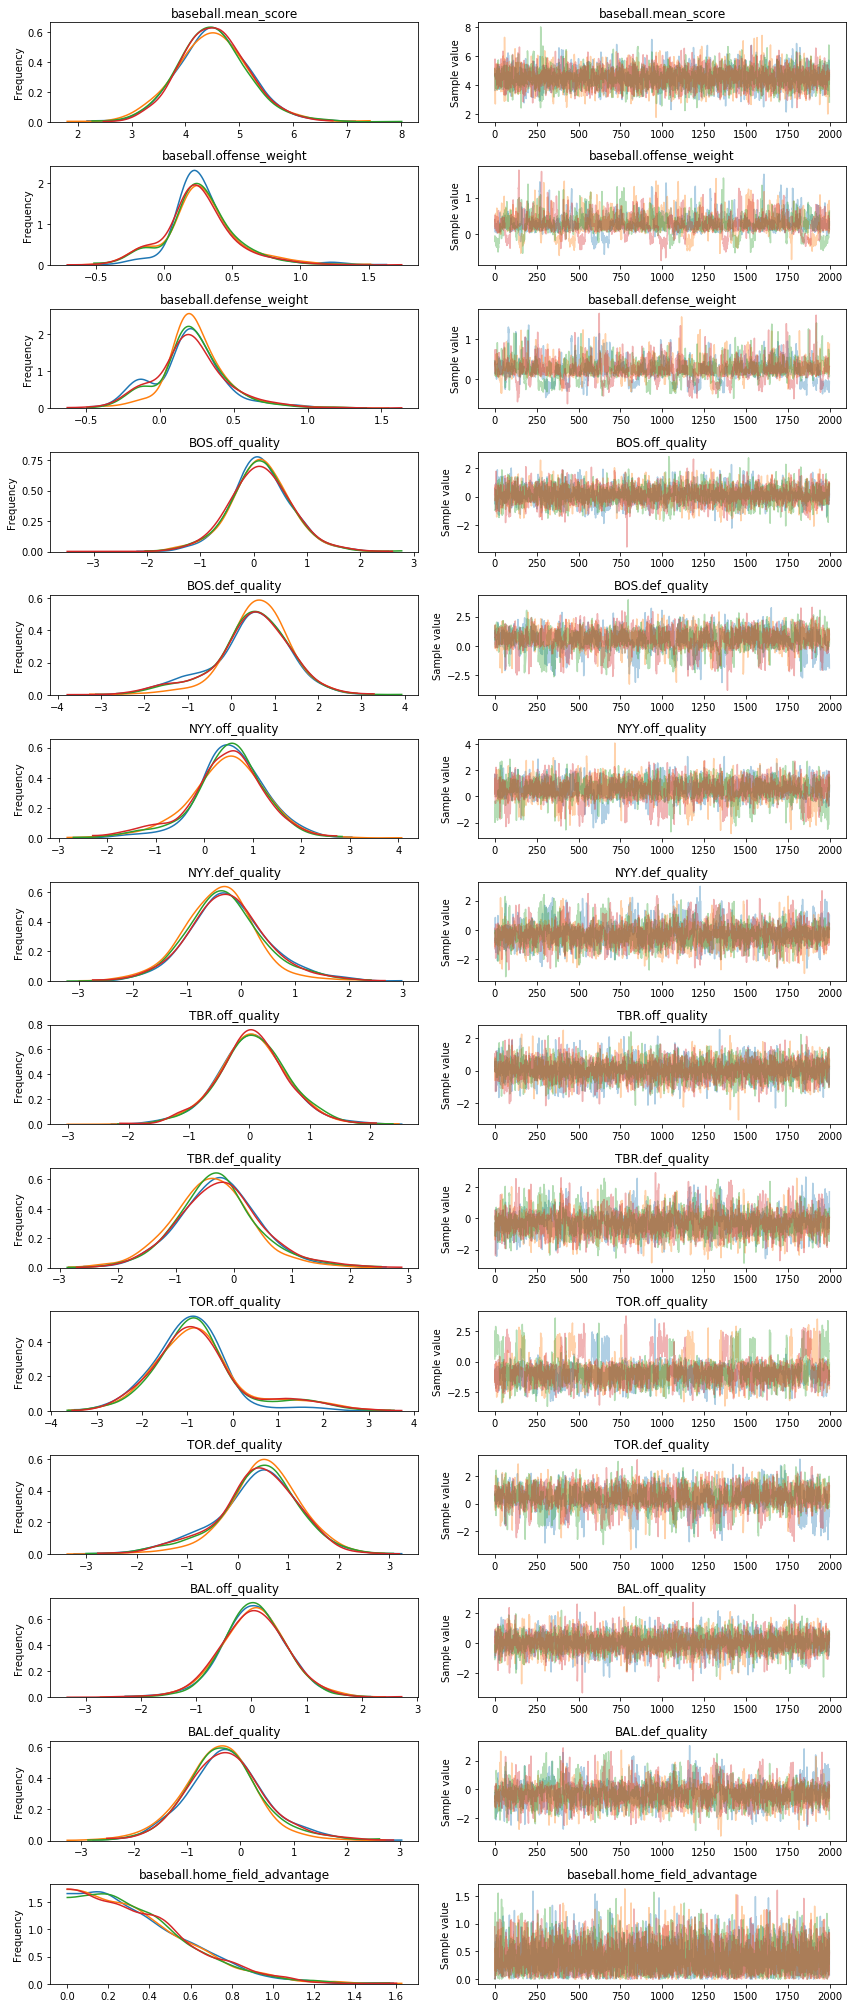

In [8]:
# Infer the posterior distributions
with model:
    trace = pm.sample(2000, tune=1000, cores=4, nuts_kwargs=dict(target_accept=.95))
    
pm.traceplot(trace);

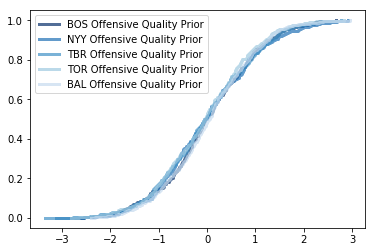

<Figure size 576x432 with 0 Axes>

In [9]:
for t in team_names:
    plotCdf(prior_trace[f'{t}.off_quality'], label=f'{t} Offensive Quality Prior')
thinkplot.Show()

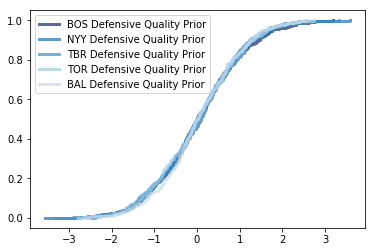

<Figure size 576x432 with 0 Axes>

In [10]:
for t in team_names:
    plotCdf(prior_trace[f'{t}.def_quality'], label=f'{t} Defensive Quality Prior')
thinkplot.Show()

The respective posterior distributions align with what we would expect from these teams qualitatively (and from looking at their first 10 inter-division games, quantitatively).

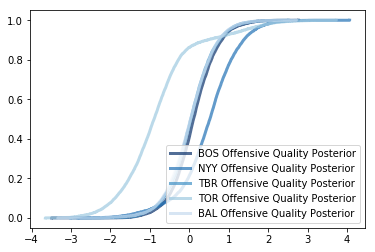

<Figure size 576x432 with 0 Axes>

In [11]:
for t in team_names:
    plotCdf(trace[f'{t}.off_quality'], label=f'{t} Offensive Quality Posterior')
thinkplot.Show()

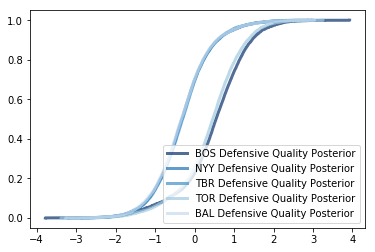

<Figure size 576x432 with 0 Axes>

In [12]:
for t in team_names:
    plotCdf(trace[f'{t}.def_quality'], label=f'{t} Defensive Quality Posterior')
thinkplot.Show()

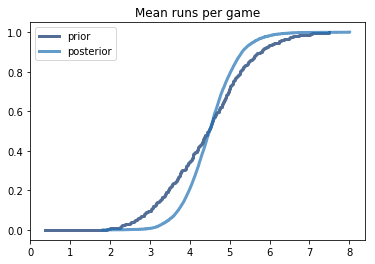

In [13]:
plotCdf(prior_trace['baseball.mean_score'], label='prior')
plotCdf(trace['baseball.mean_score'], label='posterior')
thinkplot.Config(title='Mean runs per game')

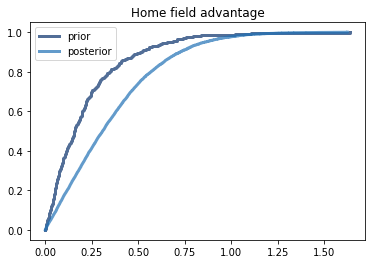

In [14]:
plotCdf(prior_trace['baseball.home_field_advantage'], label='prior')
plotCdf(trace['baseball.home_field_advantage'], label='posterior')
thinkplot.Config(title='Home field advantage')

0.2445 chance that BOS offense is better than NYY offense


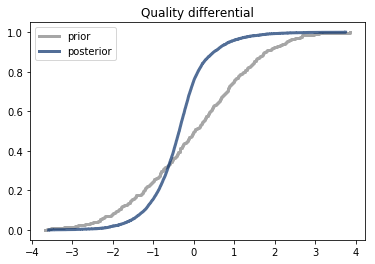

In [15]:
def plot_better(better, worse, attr, attr_name):
    plotCdf(prior_trace[f'{better}.{attr}'] - prior_trace[f'{worse}.{attr}'], label='prior', color='grey')
    plotCdf(trace[f'{better}.{attr}'] - trace[f'{worse}.{attr}'], label='posterior')
    thinkplot.Config(title='Quality differential')

    win_chance=np.mean((trace[f'{better}.{attr}'] - trace[f'{worse}.{attr}'])>0)
    print(f'{win_chance} chance that {better} {attr_name} is better than {worse} {attr_name}')

plot_better('BOS', 'NYY', 'off_quality', 'offense') # What really matters

0.833 chance that BOS defense is better than NYY defense


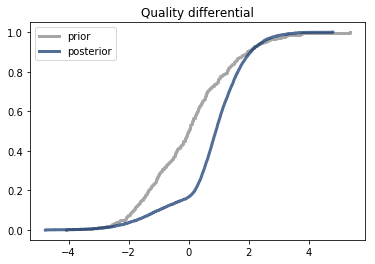

In [16]:
plot_better('BOS', 'NYY', 'def_quality', 'defense')

In [17]:
# Logic borrowed from Eric's ranking project
best_off_teams = []
best_def_teams = []
for i in range(len(trace)):
    best_off_teams.append(max(team_names, key=lambda name: trace[f'{name}.off_quality'][i]))
    best_def_teams.append(max(team_names, key=lambda name: trace[f'{name}.def_quality'][i]))

from collections import Counter

for team, count in Counter(best_off_teams).most_common():
    print(f'{team} offense is best with probability {count/len(trace)*100:.1f}%')

print()
for team, count in Counter(best_def_teams).most_common():
    print(f'{team} defense is best with probability {count/len(trace)*100:.1f}%')

NYY offense is best with probability 65.7%
BOS offense is best with probability 11.5%
BAL offense is best with probability 9.5%
TBR offense is best with probability 9.4%
TOR offense is best with probability 3.9%

BOS defense is best with probability 43.8%
TOR defense is best with probability 33.7%
NYY defense is best with probability 8.8%
BAL defense is best with probability 7.0%
TBR defense is best with probability 6.8%
